# Spotify Music Recommendation System


### Import libraries

In [ ]:
# import all libraries used in this notebook here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

### Load the dataset

In [ ]:
# load dataset
df = pd.read_csv('/content/mixed_playlist.csv')

In [ ]:
# display the correlation matrix between numeric variables
corr = df.corr(numeric_only = True)
corr.style.background_gradient(cmap = 'coolwarm')

,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature,key,mode,release_year
length,1.000000,-0.084163,0.029134,-0.115441,-0.044156,0.141942,-0.008281,-0.077831,-0.018236,-0.022138,-0.181394,-0.015309,-0.031600,0.027409,0.100697
popularity,-0.084163,1.000000,-0.038865,0.054019,0.062094,-0.142565,-0.055714,0.104607,0.041965,0.031505,0.035836,-0.014869,0.001935,-0.010423,0.065753
acousticness,0.029134,-0.038865,1.000000,-0.438107,-0.784642,0.246431,-0.111100,-0.676415,-0.179138,-0.163106,-0.318691,-0.235090,-0.044212,-0.004613,-0.023982
danceability,-0.115441,0.054019,-0.438107,1.000000,0.483286,-0.374824,0.017052,0.530318,0.253741,0.101612,0.584470,0.255975,0.030394,-0.019654,0.035778
energy,-0.044156,0.062094,-0.784642,0.483286,1.000000,-0.311187,0.151676,0.827939,0.252163,0.181401,0.479323,0.242179,0.055926,-0.035017,0.068404
instrumentalness,0.141942,-0.142565,0.246431,-0.374824,-0.311187,1.000000,-0.097716,-0.482682,-0.256475,-0.055065,-0.413844,-0.135485,-0.000998,0.003616,-0.077273
liveness,-0.008281,-0.055714,-0.111100,0.017052,0.151676,-0.097716,1.000000,0.088848,0.101497,0.029610,0.119639,-0.012848,0.010227,0.014298,-0.018481
loudness,-0.077831,0.104607,-0.676415,0.530318,0.827939,-0.482682,0.088848,1.000000,0.202353,0.162616,0.465614,0.244703,0.039321,-0.015236,0.079054
speechiness,-0.018236,0.041965,-0.179138,0.253741,0.252163,-0.256475,0.101497,0.202353,1.000000,0.030258,0.250074,0.069329,0.013950,-0.034501,0.035860
tempo,-0.022138,0.031505,-0.163106,0.101612,0.181401,-0.055065,0.029610,0.162616,0.030258,1.000000,0.095698,0.014138,0.009757,-0.057142,-0.006420


In [ ]:
# Data Cleaning/Preprocessing (Isolating Missing Values)
# Identify rows where the user or top_year label is missing (deleted)
missing_mask = (df['user'] == 'deleted by hacker') | (df['top_year'] == 'deleted by hacker')

# Partitioning the dataset
train_df = df[~missing_mask].copy()
predict_df = df[missing_mask].copy()

# We have removed feature loudeness as it is highly correlated to energy and
# moderately with dancebility
features = ['length', 'popularity', 'acousticness', 'danceability', 'energy',
            'instrumentalness', 'liveness', 'speechiness',
            'tempo', 'valence', 'release_year']

Y = train_df[features]

In [ ]:
from sklearn.feature_selection import SelectKBest, r_regression, f_classif
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Encode the categorical target variable 'y_user' to numerical labels if not already done
# Assuming y_user is defined from previous cells, otherwise, it would need to be loaded/defined.
# For safety, I'll re-include the LabelEncoder part, ensuring y_user_encoded is available.
le = LabelEncoder()
y_user_encoded = le.fit_transform(df['user'][~missing_mask]) # Use the 'user' column from the filtered DataFrame

selector_r = SelectKBest(
    score_func = f_classif, # specify Pearson correlation coefficient as the score function
    k = 5 # select the 5 best features
)
# Pass the target variable 'y_user_encoded' to the fit method
selector_r.fit(Y, y_user_encoded)

# Get the indices of the selected features
selected_feature_indices = selector_r.get_support(indices=True)

# Get the names of the selected features
k_best_features = Y.columns[selected_feature_indices]

print(f"Selected {len(k_best_features)} best features:\n{list(k_best_features)}")

Selected 5 best features:
['acousticness', 'danceability', 'energy', 'instrumentalness', 'speechiness']


In [ ]:
# Create a new DataFrame with only the selected k best features
X = Y[k_best_features]

# Display the head of the new DataFrame to confirm the selection
print("DataFrame with selected K best features:")
X.head()

DataFrame with selected K best features:


,acousticness,danceability,energy,instrumentalness,speechiness
1,0.6220,0.615,0.599,0.000008,0.2530
2,0.4130,0.834,0.734,0.000040,0.3410
3,0.4040,0.797,0.506,0.000153,0.0327
4,0.0616,0.788,0.675,0.711000,0.0318
5,0.4190,0.677,0.298,0.080200,0.0501


In [ ]:
X.head(5)

,acousticness,danceability,energy,instrumentalness,speechiness
1,0.6220,0.615,0.599,0.000008,0.2530
2,0.4130,0.834,0.734,0.000040,0.3410
3,0.4040,0.797,0.506,0.000153,0.0327
4,0.0616,0.788,0.675,0.711000,0.0318
5,0.4190,0.677,0.298,0.080200,0.0501


In [ ]:
# display the basic information
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3500 entries, 1 to 3598
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      3500 non-null   float64
 1   danceability      3500 non-null   float64
 2   energy            3500 non-null   float64
 3   instrumentalness  3500 non-null   float64
 4   speechiness       3500 non-null   float64
dtypes: float64(5)
memory usage: 164.1 KB


In [ ]:
# display the descriptive statistics of numeric variables
X.describe()

,acousticness,danceability,energy,instrumentalness,speechiness
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,0.442446,0.561711,0.509502,0.268462,0.085711
std,0.357359,0.194169,0.258818,0.377334,0.094089
min,0.000011,0.000000,0.000545,0.000000,0.000000
25%,0.079475,0.433750,0.304750,0.000002,0.036500
50%,0.382000,0.585500,0.533000,0.002165,0.046700
75%,0.800000,0.710000,0.721000,0.692000,0.087200
max,0.996000,0.971000,0.991000,0.995000,0.952000


In [ ]:
# K-Means clustering as a trial

model = KMeans(
    n_clusters = 10, # 10 clusters
    n_init = 'auto', # multiple attempt with different initial centroids
    random_state = 1, # fix ramdom state to guarantee reproducibility
    verbose = 1 # output log
)
model.fit(X)

Initialization complete
Iteration 0, inertia 258.0521182198332.
Iteration 1, inertia 213.73723506442752.
Iteration 2, inertia 210.45874558373268.
Iteration 3, inertia 208.90711824531977.
Iteration 4, inertia 208.34388648664452.
Iteration 5, inertia 208.05069500938762.
Iteration 6, inertia 207.90740200498044.
Iteration 7, inertia 207.86064696035535.
Iteration 8, inertia 207.84426652827.
Iteration 9, inertia 207.83606725435104.
Iteration 10, inertia 207.8265505510571.
Iteration 11, inertia 207.8075854579891.
Iteration 12, inertia 207.80187883997664.
Converged at iteration 12: center shift 9.14864127599743e-07 within tolerance 7.670361829482216e-06.


KMeans(n_clusters=10, random_state=1, verbose=1)

In [ ]:
# obtain the cluster centers
model.cluster_centers_

array([[0.93638333, 0.30805357, 0.12427663, 0.87534048, 0.04302048],
       [0.52860553, 0.66677638, 0.59767337, 0.01362489, 0.13310151],
       [0.12889149, 0.5745042 , 0.67506723, 0.45894958, 0.07197983],
       [0.74497727, 0.56114899, 0.38439646, 0.04459669, 0.07010783],
       [0.17910788, 0.52213854, 0.49358681, 0.01573245, 0.07545833],
       [0.66222936, 0.49726422, 0.44499358, 0.81388991, 0.05603028],
       [0.90151976, 0.423169  , 0.16792231, 0.0450106 , 0.04964347],
       [0.08520842, 0.59700117, 0.66917302, 0.82976833, 0.05884282],
       [0.05615971, 0.59198035, 0.81495088, 0.01682981, 0.09324656],
       [0.17500868, 0.78371577, 0.67059751, 0.01242644, 0.15520664]])

In [ ]:
# display the cluster centers from the K-Means model
model.cluster_centers_

array([[0.93638333, 0.30805357, 0.12427663, 0.87534048, 0.04302048],
       [0.52860553, 0.66677638, 0.59767337, 0.01362489, 0.13310151],
       [0.12889149, 0.5745042 , 0.67506723, 0.45894958, 0.07197983],
       [0.74497727, 0.56114899, 0.38439646, 0.04459669, 0.07010783],
       [0.17910788, 0.52213854, 0.49358681, 0.01573245, 0.07545833],
       [0.66222936, 0.49726422, 0.44499358, 0.81388991, 0.05603028],
       [0.90151976, 0.423169  , 0.16792231, 0.0450106 , 0.04964347],
       [0.08520842, 0.59700117, 0.66917302, 0.82976833, 0.05884282],
       [0.05615971, 0.59198035, 0.81495088, 0.01682981, 0.09324656],
       [0.17500868, 0.78371577, 0.67059751, 0.01242644, 0.15520664]])

In [ ]:
# obtain clustering results
model.labels_

array([1, 9, 1, ..., 0, 6, 8], dtype=int32)

In [ ]:
# obtain the inertia
model.inertia_

207.80110258474087

### Select the best K value through Elbow method

Different values of K will lead to different results. Without any prior knowledge, it is difficult to assume a proper K value. We can use Elbow method to select K value based on a specified metric.

`sklearn` use inertia as the default criteria to determine when the model converge. We can also use inertia to select the value of K.

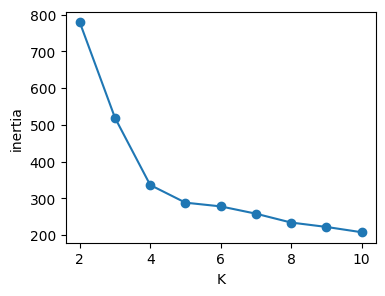

In [ ]:
# create an empty list to store inertia
inertia =[]

# test different k values
for k in range(2, 11):
    model = KMeans(
        n_clusters = k,
        n_init = 'auto',
        random_state = 1,
        verbose = 0
    ).fit(X)
    inertia.append(model.inertia_)

# plot k vs inertia
plt.figure(figsize = (4, 3))
plt.plot(range(2, 11), inertia, marker = 'o')
plt.xlabel('K')
plt.ylabel('inertia')
plt.show()

The figure shows that the inertia decreases as k increases but we can still verify it using another metrics such as Silhouette Coefficient, Calinski-Harabasz Index and Davies-Bouldin Index

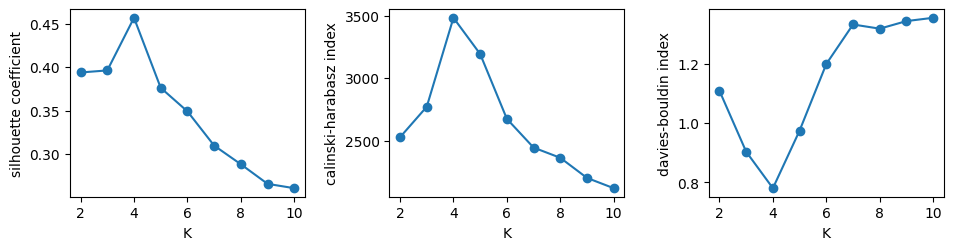

In [ ]:
# create an empty list to store silhouette coefficient
silhouette = []
calinski_harabasz = []
davies_bouldin = []

# test different k values
for k in range(2, 11):
    model = KMeans(
        n_clusters = k,
        n_init = 'auto',
        random_state = 1,
        verbose = 0
    ).fit(X)
    silhouette.append(silhouette_score(X, model.labels_))
    calinski_harabasz.append(calinski_harabasz_score(X, model.labels_))
    davies_bouldin.append(davies_bouldin_score(X, model.labels_))

# plot k vs silhouette coefficient
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 3))
fig.tight_layout(pad = 3)
axs[0].plot(range(2, 11), silhouette, marker = 'o')
axs[0].set_xlabel('K')
axs[0].set_ylabel('silhouette coefficient')
axs[1].plot(range(2, 11), calinski_harabasz, marker = 'o')
axs[1].set_xlabel('K')
axs[1].set_ylabel('calinski-harabasz index')
axs[2].plot(range(2, 11), davies_bouldin, marker = 'o')
axs[2].set_xlabel('K')
axs[2].set_ylabel('davies-bouldin index')
plt.show()

Considering the four metrics, we will use 5 as the K value.

In [ ]:
# reconstruct the clustering model with k=5

model = Pipeline(
    [
        ('standard scaler', StandardScaler()),
        ('k-nearest neighbors', KMeans(n_clusters = 5, n_init = 'auto',
          random_state = 1,verbose = 1
        ))
    ]
)

model.fit(X)

Initialization complete
Iteration 0, inertia 11072.696279451253.
Iteration 1, inertia 7423.02562004782.
Iteration 2, inertia 6205.688499180242.
Iteration 3, inertia 5860.974322950666.
Iteration 4, inertia 5767.355903128486.
Iteration 5, inertia 5742.825175301297.
Iteration 6, inertia 5734.454194068907.
Iteration 7, inertia 5733.872861812471.
Converged at iteration 7: center shift 9.68570026233015e-05 within tolerance 0.00010000000000000029.


Pipeline(steps=[('standard scaler', StandardScaler()),
                ('k-nearest neighbors',
                 KMeans(n_clusters=5, random_state=1, verbose=1))])

### Interpret the results

After we got the clustering results, the most important step is to try to interpret the results.

To understand these natural clusters, the easiest way is to visualize the results.

In [ ]:
# Get the StandardScaler from the pipeline and transform X
scaler = model.named_steps['standard scaler']
X_scaled = scaler.transform(X)

# Get the cluster labels from the KMeans step
cluster_labels = model.named_steps['k-nearest neighbors'].labels_

# Create a new DataFrame with scaled features and cluster labels
X_scaled_df = pd.DataFrame(X_scaled, columns=k_best_features, index=X.index)
clustered_scaled_df = X_scaled_df.copy()
clustered_scaled_df['cluster'] = cluster_labels

# Display the head of the new DataFrame to confirm the preparation
print("DataFrame with scaled K best features and cluster labels:")
display(clustered_scaled_df.head())

DataFrame with scaled K best features and cluster labels:


,acousticness,danceability,energy,instrumentalness,speechiness,cluster
1,0.502520,0.274485,0.345843,-0.711550,1.778239,2
2,-0.082410,1.402531,0.867519,-0.711465,2.713655,2
3,-0.107598,1.211948,-0.013534,-0.711165,-0.563492,1
4,-1.065875,1.165590,0.639527,1.172971,-0.573058,3
5,-0.065617,0.593841,-0.817301,-0.498997,-0.378534,4


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools

# Get the feature names from the columns of clustered_scaled_df, excluding the 'cluster' column
features_for_plotting = [col for col in clustered_scaled_df.columns if col != 'cluster']

# Generate all unique combinations of three features
feature_combinations = list(itertools.combinations(features_for_plotting, 3))

# Create 3D scatter plots for each combination
for i, (feat1, feat2, feat3) in enumerate(feature_combinations):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot, colored by cluster
    scatter = ax.scatter(
        clustered_scaled_df[feat1],
        clustered_scaled_df[feat2],
        clustered_scaled_df[feat3],
        c=clustered_scaled_df['cluster'],
        cmap='viridis', # Colormap for clusters
        s=50 # Marker size
    )

    # Set labels and title
    ax.set_xlabel(feat1)
    ax.set_ylabel(feat2)
    ax.set_zlabel(feat3)
    ax.set_title(f'3D Scatter Plot of {feat1}, {feat2}, and {feat3} by Cluster')

    # Add a color bar
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pandas as pd
# formalize cluster centroids
cluster_centers = pd.DataFrame(
    model['k-nearest neighbors'].cluster_centers_,
    columns = k_best_features # Use k_best_features for column names
)
cluster_centers

,acousticness,danceability,energy,instrumentalness,speechiness
0,1.206635,-1.226392,-1.264117,1.565621,-0.447995
1,-0.713361,0.512176,0.692876,-0.653222,-0.123988
2,-0.415572,0.570393,0.579371,-0.623772,2.584258
3,-0.754589,0.138227,0.561425,1.334396,-0.331606
4,0.883260,-0.273109,-0.767843,-0.569026,-0.350114


### Make predictions

Given an unseen customer, if we know her or his age, annual income level and spending score, then we can use the learned model to assign this customer into one cluster.

In [ ]:
# define a new customer using only the k_best_features
new_data = pd.DataFrame(
    {
        'acousticness': [0.419],
        'danceability': [0.677],
        'energy': [0.298],
        'instrumentalness': [0.0802],
        'speechiness': [0.0501]
    }
)
new_data

,acousticness,danceability,energy,instrumentalness,speechiness
0,0.419,0.677,0.298,0.0802,0.0501


In [ ]:
# assign this customer into one cluster
model.predict(new_data)

array([4], dtype=int32)

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# Get the predicted cluster for the new_data point
predicted_cluster = model.predict(new_data)

# Add cluster labels to X if not already done, or use the clustered_selected_df
# Assuming clustered_selected_df is available from previous steps and has 'cluster' column
# If not, you'd create it: clustered_selected_df = X.copy(); clustered_selected_df['cluster'] = model.labels_

# Filter the original dataset (X) to include only points from the predicted cluster
# Make sure to use the same features that were used for clustering (k_best_features if you used them, or just X if all features were used)
# If you used X for clustering and not X_selected_kbest:
points_in_predicted_cluster = X[model['k-nearest neighbors'].labels_ == predicted_cluster]

# Calculate distances from new_data to all points in the predicted cluster
# Ensure new_data has the same columns and order as points_in_predicted_cluster
new_data_aligned = new_data[points_in_predicted_cluster.columns]
distances = euclidean_distances(new_data_aligned, points_in_predicted_cluster)

# Find the index of the nearest point within that cluster
nearest_point_index_in_cluster = distances.argmin()

# Get the actual nearest point from the original X DataFrame
nearest_point = points_in_predicted_cluster.iloc[nearest_point_index_in_cluster]

print(f"Predicted cluster for new_data: {predicted_cluster}")
print("\nNearest point in the predicted cluster with all its feature values:")
print(nearest_point)

Predicted cluster for new_data: [4]

Nearest point in the predicted cluster with all its feature values:
acousticness        0.4190
danceability        0.6770
energy              0.2980
instrumentalness    0.0802
speechiness         0.0501
Name: 5, dtype: float64


In [ ]:
# Get the index of the nearest point
nearest_point_index = nearest_point.name

# Retrieve the 'name' column from the original DataFrame 'df' using this index
song_name = df.loc[nearest_point_index, 'name']

print(f"The song name for the nearest point is: {song_name}")

The song name for the nearest point is: Soothing


In [ ]:
# Filter clustered_scaled_df to get all points in the predicted cluster
songs_in_predicted_cluster = clustered_scaled_df[clustered_scaled_df['cluster'] == predicted_cluster[0]]

# Exclude the nearest_point from the suggestions
songs_for_suggestion = songs_in_predicted_cluster[songs_in_predicted_cluster.index != nearest_point_index]

# Sample 5 random songs from this filtered list
# Ensure there are enough songs to sample from, otherwise take all available
num_suggestions = min(10, len(songs_for_suggestion))
if num_suggestions > 0:
    suggested_songs_indices = songs_for_suggestion.sample(n=num_suggestions, random_state=42).index

    # Get the names of the suggested songs from the original DataFrame df
    suggested_song_names = df.loc[suggested_songs_indices, 'name']

    print(f"\n{num_suggestions} Song Suggestions from Cluster {predicted_cluster[0]}:")
    display(suggested_song_names)
else:
    print(f"No other songs available in cluster {predicted_cluster[0]} for suggestion, besides the nearest point.")


10 Song Suggestions from Cluster 4:


,name
2918,Sherry Fm
1609,Kerozen
517,Starry Starry Night
2973,Petits d'anges (with Sophie Tith)
175,The Call
323,Lundi Méchant
1330,Make Believe
1163,Somewhere (Dirty Blvd.) - Bonus Track [Extende...
2786,you were good to me
3561,Reuben's Train
